In [150]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [151]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#PART ONE

Import Dataset

In [152]:
img_data = np.load('/content/drive/MyDrive/Advanced Computer Vision/Dataset- Images.npy', allow_pickle=True)

In [153]:
img_data.shape

(409, 2)

In [154]:
img_data[0][1]

[{'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
 {'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}]

In [155]:
img_height = 192
img_width = 192

In [156]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(img_data.shape[0]), img_height, img_width))
X = np.zeros((int(img_data.shape[0]), img_height, img_width, 3))
for index in range(img_data.shape[0]):
    img = img_data[index][0]
    img = cv2.resize(img, dsize=(img_height, img_width), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in img_data[index][1]:
        x1 = int(i["points"][0]['x'] * img_width)
        x2 = int(i["points"][1]['x'] * img_width)
        y1 = int(i["points"][0]['y'] * img_height)
        y2 = int(i["points"][1]['y'] * img_height)
        masks[index][y1:y2, x1:x2] = 1

In [157]:
X_train = X[:325]
X_test = X[325:]
y_train = masks[:325]
y_test = masks[325:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


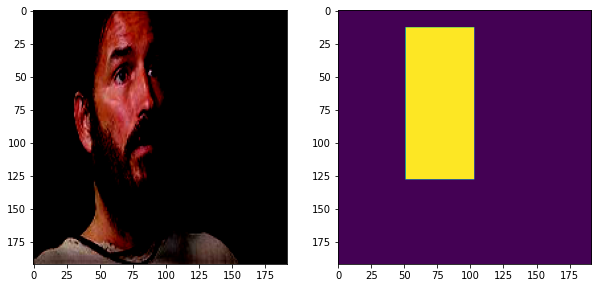

In [158]:
# Printing X_train[75])
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(X_train[75])
fig.add_subplot(1, 2, 2)
plt.imshow(y_train[75])
plt.show()

## Mask Detection Model

In [159]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(img_height, img_width, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    layer1 = model.get_layer("conv_pw_1_relu").output
    layer2= model.get_layer("conv_pw_3_relu").output
    layer3= model.get_layer("conv_pw_5_relu").output
    layer4 = model.get_layer("conv_pw_11_relu").output
    layer5 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(layer5), layer4])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), layer3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), layer2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), layer1])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((img_height, img_width))(x)
    print(x.shape)

    return Model(inputs=model.input, outputs=x)

In [160]:
model = create_model()

17235968/17225924 [==============================] - 1s 0us/step
(None, 12, 12, 1536)
(None, 24, 24, 1792)
(None, 48, 48, 1920)
(None, 96, 96, 1984)
(None, 192, 192, 1984)
(None, 192, 192)


### Print model summary 

In [161]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 96, 96, 32)   864         ['input_5[0][0]']                
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 96, 96, 32)   128         ['conv1[0][0]']                  
                                                                                                  
 conv1_relu (ReLU)              (None, 96, 96, 32)   0           ['conv1_bn[0][0]']         

### Dice coefficient


In [162]:
from tensorflow import reduce_sum
from tensorflow.keras.backend import epsilon

def dice_coefficient(y_true, y_pred):
    numerator = 2 * reduce_sum(y_true * y_pred)
    denominator = reduce_sum(y_true + y_pred)
    return numerator / (denominator + epsilon())

### Loss function 

In [163]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Model Compilation

In [164]:
model.compile(loss=loss, optimizer='adam', metrics=[dice_coefficient])

In [165]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("mask_detection_model.h5", monitor="loss", verbose=1, save_best_only=True,save_weights_only=True, mode="min")

In [166]:
model.fit(X_train, y_train, epochs=15, batch_size=1, callbacks=[checkpoint])

Epoch 1/15
325/325 [==============================] - ETA: 0s - loss: 1.2760 - dice_coefficient: 0.4987
Epoch 00001: loss improved from inf to 1.27595, saving model to mask_detection_model.h5
325/325 [==============================] - 32s 85ms/step - loss: 1.2760 - dice_coefficient: 0.4987
Epoch 2/15
325/325 [==============================] - ETA: 0s - loss: 0.9005 - dice_coefficient: 0.5869
Epoch 00002: loss improved from 1.27595 to 0.90050, saving model to mask_detection_model.h5
325/325 [==============================] - 27s 83ms/step - loss: 0.9005 - dice_coefficient: 0.5869
Epoch 3/15
325/325 [==============================] - ETA: 0s - loss: 0.7138 - dice_coefficient: 0.6533
Epoch 00003: loss improved from 0.90050 to 0.71378, saving model to mask_detection_model.h5
325/325 [==============================] - 27s 83ms/step - loss: 0.7138 - dice_coefficient: 0.6533
Epoch 4/15
325/325 [==============================] - ETA: 0s - loss: 0.6354 - dice_coefficient: 0.6818
Epoch 00004: lo

### Prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


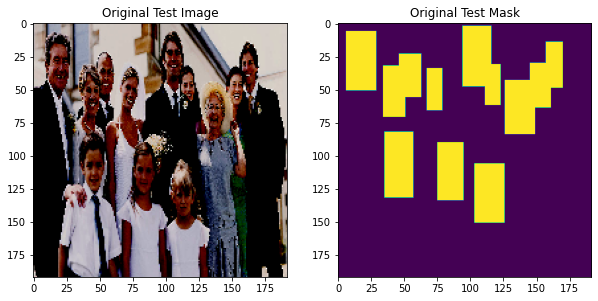

In [167]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.title("Original Test Image")
plt.imshow(X_test[69])
fig.add_subplot(1, 2, 2)
plt.title("Original Test Mask")
plt.imshow(y_test[69])
plt.show()

In [168]:
pred = cv2.resize(1.0 * (model.predict(x=np.array([X_test[69]]))[0] > 0.6), (img_width, img_height)) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


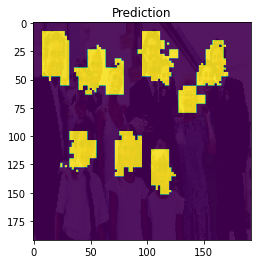

In [169]:
plt.title("Prediction")
plt.imshow(X_test[69])
plt.imshow(pred, alpha=0.9)

In [170]:
#image = plt.imread("/content/drive/MyDrive/Advanced Computer Vision/Prediction_Image.jpeg")
#plt.imshow(image)

filename = '/content/drive/MyDrive/Advanced Computer Vision/Prediction_Image.jpeg'
unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (img_width, img_height))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [171]:
y_pred = model.predict(np.array([feat_scaled]))
y_pred

array([[[1.8923133e-19, 1.8923133e-19, 2.4511158e-19, ...,
         1.3138055e-12, 1.1635653e-12, 1.1635653e-12],
        [1.8923133e-19, 1.8923133e-19, 2.4511158e-19, ...,
         1.3138055e-12, 1.1635653e-12, 1.1635653e-12],
        [1.8279324e-19, 1.8279324e-19, 2.0163251e-19, ...,
         1.2604415e-12, 1.2154006e-12, 1.2154006e-12],
        ...,
        [2.9001114e-18, 2.9001114e-18, 4.8189218e-18, ...,
         2.8066551e-12, 1.4125729e-12, 1.4125729e-12],
        [3.2767056e-18, 3.2767056e-18, 5.2057487e-18, ...,
         2.8077315e-12, 1.7052408e-12, 1.7052408e-12],
        [3.2767056e-18, 3.2767056e-18, 5.2057487e-18, ...,
         2.8077315e-12, 1.7052408e-12, 1.7052408e-12]]], dtype=float32)

In [172]:
pred_new_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (img_width,img_height))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


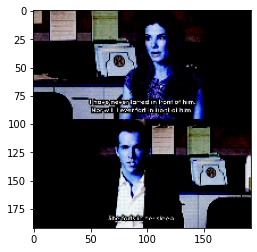

In [173]:
plt.imshow(feat_scaled)

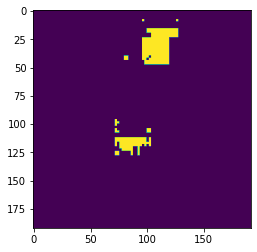

In [174]:
plt.imshow(pred_new_mask)

#PART TWO

In [1]:
#pip install labelImg

Note: you may need to restart the kernel to use updated packages.


In [3]:
!python generate_dataset.py

class real: 100 images
1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100
100/100

Done!


In [34]:
pwd

'C:\\Users\\002N20744\\Downloads\\images'

In [35]:
import os
os.listdir('C:\\Users\\002N20744\\Downloads\\images')

['desktop.ini',
 'real_00001.jpg',
 'real_00001.xml',
 'real_00002.jpg',
 'real_00002.xml',
 'real_00003.jpg',
 'real_00003.xml',
 'real_00004.jpg',
 'real_00004.xml',
 'real_00005.jpg',
 'real_00005.xml',
 'real_00006.jpg',
 'real_00006.xml',
 'real_00007.jpg',
 'real_00007.xml',
 'real_00008.jpg',
 'real_00008.xml',
 'real_00009.jpg',
 'real_00009.xml',
 'real_00010.jpg',
 'real_00010.xml',
 'real_00011.jpg',
 'real_00011.xml',
 'real_00012.jpg',
 'real_00012.xml',
 'real_00013.jpg',
 'real_00013.xml',
 'real_00014.jpg',
 'real_00014.xml',
 'real_00015.jpg',
 'real_00015.xml',
 'real_00016.jpg',
 'real_00016.xml',
 'real_00017.jpg',
 'real_00017.xml',
 'real_00018.jpg',
 'real_00018.xml',
 'real_00019.jpg',
 'real_00019.xml',
 'real_00020.jpg',
 'real_00020.xml',
 'real_00021.jpg',
 'real_00021.xml',
 'real_00022.jpg',
 'real_00022.xml',
 'real_00023.jpg',
 'real_00023.xml',
 'real_00024.jpg',
 'real_00024.xml',
 'real_00025.jpg',
 'real_00025.xml',
 'real_00026.jpg',
 'real_00026.xm

In [36]:
import pandas as pd

In [62]:
df=pd.read_csv("C:\\Users\\002N20744\\Downloads\\train.csv", header=None,skip_blank_lines=True ,
                       names=['File', 'Height','Width','xmin',
                              'ymin','xmax', 'ymax','Class','Total_Faces'])

In [63]:
df =df.dropna().reset_index().drop(columns=["index","Height","Width"])

In [64]:
df.head()

,File,xmin,ymin,xmax,ymax,Class,Total_Faces
0,images/real_00001.jpg,21.0,2.0,586.0,591.0,real_00001,1.0
1,images/real_00002.jpg,81.0,4.0,520.0,582.0,real_00002,1.0
2,images/real_00003.jpg,65.0,11.0,572.0,573.0,real_00003,1.0
3,images/real_00004.jpg,80.0,8.0,488.0,563.0,real_00004,1.0
4,images/real_00005.jpg,110.0,4.0,491.0,563.0,real_00005,1.0


#CHALLENGES FACED

1. Creating the Bounding box using LabelImg or any other known means available today with the label is manual and is laborious and requires lots of time.
2. The process was intensive and prone to human error.